# Executive Summary

### Problem: to identify Madrid districts based on a preliminary combined ranking of several data attributes, including pollution levels, number of incidents and number of FourSquare top venues. This analysis can be further extended to incorporate multiple attributes e.g. crime rates, traffic incidents, land price per square meter, etc

### Target Audience: general population or businesses interested in shortlisting the districts to live or work in.

# Data used:

#### Analysis performed is based on 4 datasets from Madrid:
####      1 - Madrid Districts coordinates - Source: Wikipedia

####      2 - 2019 Pollution dataset - Source: report from 'Ecologistas en Acción' (Air quality report 2019)
####      https://www.ecologistasenaccion.org/wp-content/uploads/2020/01/info-calidad-aire-madrid-2019.pdf

####      3 - 2019 Incidents dataset - Source: https://datos.madrid.es/

####      4 - FourSquare venue data via API connection

#### GeoJson:  https://team.carto.com/u/jsanz/tables/distritos/public
#### GeoJason tweaked with https://geoman.io

#### Links to datasources can be found below

In [1]:
# Instalations
!pip install azureml
!ls ~/library
!pip install sklearn-pandas
!pip -q install folium
!pip install tabula-py
!pip install geojson
print("instalations done - MON")

You should consider upgrading via the 'pip install --upgrade pip' command.
AS_MADRID_DATA_ANALYSIS_v2-Copy10.ipynb  AS_MADRID_DATA_ANALYSIS_v2-Copy9.ipynb
AS_MADRID_DATA_ANALYSIS_v2-Copy1.ipynb	 AS_MADRID_DATA_ANALYSIS_v2-Copy.ipynb
AS_MADRID_DATA_ANALYSIS_v2-Copy2.ipynb	 AS_MADRID_DATA_ANALYSIS_v2.ipynb
AS_MADRID_DATA_ANALYSIS_v2-Copy3.ipynb	 DEAD_KERNEL_AS-MADRID_ANALYSIS.ipynb
AS_MADRID_DATA_ANALYSIS_v2-Copy4.ipynb	 madrid_distritos.geojson
AS_MADRID_DATA_ANALYSIS_v2-Copy5.ipynb	 MADRID_DISTRITOS_GPS_WIKI.xls
AS_MADRID_DATA_ANALYSIS_v2-Copy6.ipynb	 POLUCION_MEDIAS_2019.xls
AS_MADRID_DATA_ANALYSIS_v2-Copy7.ipynb	 README.md
AS_MADRID_DATA_ANALYSIS_v2-Copy8.ipynb	 sic_avisos_recepcionados_2019.csv
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 10.4MB 42kB/s  eta 0:00:01    |███████▌                        | 2.5MB 3.2MB/s eta 0:00:03     |███████

In [71]:
# import libraries
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#from sklearn.linear_model import LogisticRegression
#from azureml.explain.model.tabular_explainer import TabularExplainer
from sklearn_pandas import DataFrameMapper
import pandas as pd
import numpy as np
import folium
import json
import urllib
import urllib.request
from urllib.request import urlopen
import tabula # to scrape table data from PDF
import geojson
import matplotlib.pyplot as plt
import seaborn as sns
import requests # library to handle requests
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
print("libraries imported again")

libraries imported again


# DATA SECTION

In [3]:
# After extensive search, I decided to manually create a simple list of Madrid's 21 districts and their coordinates using wikipedia
# of course, feel free to use
df_Madrid_Districts_GPS = pd.read_excel('MADRID_DISTRITOS_GPS_WIKI.xls', index_col=0)
df_Madrid_Districts_GPS

,DISTRITO,LAT,LON
coddistrit,,,
1,Centro,40.415347,-3.707371
2,Arganzuela,40.402733,-3.695403
3,Retiro,40.408072,-3.676729
4,Salamanca,40.430000,-3.677778
5,Chamartin,40.453333,-3.677500
6,Tetuan,40.460556,-3.700000
7,Chamberi,40.432792,-3.697186
8,Fuencarral - El Pardo,40.478611,-3.709722
9,Moncloa - Aravaca,40.435151,-3.718765


In [4]:
# create MADRID map
MADRID_map_districts = folium.Map(location=[40.4165001, -3.7025599], zoom_start=11) # Madrid GPS coordinates, zoom level of 11

# visualize district markers in the map - wikipedia coordinates
for index, row in df_Madrid_Districts_GPS.iterrows():
    label = folium.Popup(str([row["DISTRITO"]]))
    folium.CircleMarker(location=[row["LAT"], row["LON"]],
    color='#5cb85c',
    popup=label).add_to(MADRID_map_districts)

MADRID_map_districts

In [5]:
# Scrape Madrid 2019 pollution data from PDF: pages 8 and 22 only

file = "https://www.ecologistasenaccion.org/wp-content/uploads/2020/01/info-calidad-aire-madrid-2019.pdf"

df_POL_STATIONS = tabula.read_pdf(file, pages = 8, multiple_tables = False)
df_POL_STATIONS

[    Unnamed: 0                    Unnamed: 1  \
 0          NaN                          Zona   
 1          NaN                           NaN   
 2          1.0                           NaN   
 3          NaN                           NaN   
 4          NaN                           NaN   
 5          NaN                           NaN   
 6          NaN                           NaN   
 7          NaN                           NaN   
 8          NaN                           NaN   
 9          NaN                           NaN   
 10         NaN                           NaN   
 11         NaN                           NaN   
 12         2.0                           NaN   
 13         NaN                           NaN   
 14         NaN                           NaN   
 15         3.0                           NaN   
 16         NaN                           NaN   
 17         NaN                           NaN   
 18         NaN                           NaN   
 19         NaN     

In [6]:
# PDF Output table needs extensive wrangling, so used Power BI Desktop (free license) as a time saver here, 
# and time saved was very much appreciated by my family ;-)
# Pollution output file: POLUCION_MEDIAS_2019.xls
# Load xls file with 2019 pollution data -- /home/nbuser/project/2019_POLUCION_MEDIAS.xls
# source https://www.ecologistasenaccion.org/wp-content/uploads/2020/01/info-calidad-aire-madrid-2019.pdf
df_District_Pollution_2019 = pd.read_excel('POLUCION_MEDIAS_2019.xls', index_col=0)
df_District_Pollution_2019

,Table011_(Page 8)_DISTRITO_ESTACION.Distrito,ESTACION,TIPO,NO2_Media_anual_(µg/m^{3} ),PM10_Media_anual_\n(µg/m^{3} )_1,PM2.5_Media_anual_\n(µg/m^{3} )_2,O3_Nº superac_valor_recom_OMS_octohorario_100_g/m3
id,,,,,,,
1,Usera,Plaza Elíptica,Tráfico,53,20.0,12.0,34.0
2,Moncloa - Aravaca,Plaza de España,Tráfico,40,NaN,NaN,NaN
3,Salamanca,Esc. Aguirre,Tráfico,51,21.0,10.0,42.0
4,Chamartin,Ramón y Cajal,Tráfico,39,NaN,NaN,NaN
5,Chamberi,Cuatro Caminos,Tráfico,38,19.0,10.0,NaN
6,Villaverde,Villaverde,FU,39,NaN,NaN,82.0
7,Fuencarral - El Pardo,Barrio del Pilar,Tráfico,36,NaN,NaN,87.0
8,Barajas,Urb. Embajada,FU,38,21.0,NaN,NaN
9,Chamartin,Castellana,Tráfico,34,18.0,9.0,NaN


In [7]:
# 2019 Pollution dataframe: counting number of NaN to discard column withnhigher number of NaN
# NO2 annual average values are all informed
PM10_count_NaN = df_District_Pollution_2019["PM10_Media_anual_\n(µg/m^{3} )_1"].isna().sum()
PM25_count_NaN = df_District_Pollution_2019["PM2.5_Media_anual_\n(µg/m^{3} )_2"].isna().sum()
Ozone_count_NaN = df_District_Pollution_2019["O3_Nº superac_valor_recom_OMS_octohorario_100_g/m3"].isna().sum()

print("PM10 NaN: ", PM10_count_NaN)
print("PM25 NaN: ", PM25_count_NaN) # this column will be dropped
print("Ozone O3 NaN: ", Ozone_count_NaN)

PM10 NaN:  11
PM25 NaN:  16
Ozone O3 NaN:  10


In [8]:
# Dropping 'PM2.5_Media_anual_\n(µg/m^{3} )_2' column due to number of NaN values

df_reduced_District_Pollution_2019 = df_District_Pollution_2019.drop(['PM2.5_Media_anual_\n(µg/m^{3} )_2'], axis=1)

# Rename columns in dataframe
df_reduced_District_Pollution_2019.columns = ['DISTRITO','ESTACION','TIPO','NO2','PM10', 'OZONE']

df_reduced_District_Pollution_2019.head()

,DISTRITO,ESTACION,TIPO,NO2,PM10,OZONE
id,,,,,,
1,Usera,Plaza Elíptica,Tráfico,53,20.0,34.0
2,Moncloa - Aravaca,Plaza de España,Tráfico,40,NaN,NaN
3,Salamanca,Esc. Aguirre,Tráfico,51,21.0,42.0
4,Chamartin,Ramón y Cajal,Tráfico,39,NaN,NaN
5,Chamberi,Cuatro Caminos,Tráfico,38,19.0,NaN


In [9]:
# Note that the pollution data has several districts repeated whilst missing a few others.
# NaN values will be replaced in dataframe with mean.
imp = SimpleImputer(missing_values=np.nan,strategy='mean')
imp.fit(df_reduced_District_Pollution_2019[['NO2', 'PM10','OZONE']])
df_reduced_District_Pollution_2019[['NO2', 'PM10','OZONE']]=imp.transform(df_reduced_District_Pollution_2019[['NO2', 'PM10','OZONE']])

# Simplifying dataframe dropping ESTACION and TIPO columns
df_reduced_District_Pollution_2019 = df_reduced_District_Pollution_2019.drop(['ESTACION', 'TIPO'], axis=1)

df_reduced_District_Pollution_2019

,DISTRITO,NO2,PM10,OZONE
id,,,,
1,Usera,53.0,20.000000,34.000000
2,Moncloa - Aravaca,40.0,17.461538,80.428571
3,Salamanca,51.0,21.000000,42.000000
4,Chamartin,39.0,17.461538,80.428571
5,Chamberi,38.0,19.000000,80.428571
6,Villaverde,39.0,17.461538,82.000000
7,Fuencarral - El Pardo,36.0,17.461538,87.000000
8,Barajas,38.0,21.000000,80.428571
9,Chamartin,34.0,18.000000,80.428571


In [10]:
# Repeated districts will be grouped with mean value
df_Grouped_District_Pollution_2019 = df_reduced_District_Pollution_2019.groupby('DISTRITO').mean()
df_Grouped_District_Pollution_2019

,NO2,PM10,OZONE
DISTRITO,,,
Arganzuela,34.000000,17.000000,80.428571
Barajas,33.333333,18.641026,94.476190
Carabanchel,33.000000,16.000000,123.000000
Centro,36.000000,17.461538,18.000000
Chamartin,36.500000,17.730769,80.428571
Chamberi,38.000000,19.000000,80.428571
Ciudad Lineal,34.000000,17.461538,1.000000
Fuencarral - El Pardo,25.666667,15.974359,110.000000
Hortaleza,31.000000,14.000000,80.428571


In [11]:
# Adding 3 missing districts with NaN with left outer join on 'DISTRITO' 
df_Joined_Districts_Pollution = pd.merge(df_Madrid_Districts_GPS,df_Grouped_District_Pollution_2019 , on='DISTRITO', how='left')
df_Joined_Districts_Pollution

,DISTRITO,LAT,LON,NO2,PM10,OZONE
0,Centro,40.415347,-3.707371,36.000000,17.461538,18.000000
1,Arganzuela,40.402733,-3.695403,34.000000,17.000000,80.428571
2,Retiro,40.408072,-3.676729,25.000000,17.461538,96.000000
3,Salamanca,40.430000,-3.677778,51.000000,21.000000,42.000000
4,Chamartin,40.453333,-3.677500,36.500000,17.730769,80.428571
5,Tetuan,40.460556,-3.700000,37.000000,18.000000,80.428571
6,Chamberi,40.432792,-3.697186,38.000000,19.000000,80.428571
7,Fuencarral - El Pardo,40.478611,-3.709722,25.666667,15.974359,110.000000
8,Moncloa - Aravaca,40.435151,-3.718765,30.000000,15.230769,99.214286
9,Latina,40.402461,-3.741294,NaN,NaN,NaN


In [12]:
# NaN values will be replaced again in dataframe with mean
imp_repeated = SimpleImputer(missing_values=np.nan,strategy='mean')
imp_repeated.fit(df_Joined_Districts_Pollution[['NO2', 'PM10','OZONE']])
df_Joined_Districts_Pollution[['NO2', 'PM10','OZONE']]=imp.transform(df_Joined_Districts_Pollution[['NO2', 'PM10','OZONE']])
df_Joined_Districts_Pollution

,DISTRITO,LAT,LON,NO2,PM10,OZONE
0,Centro,40.415347,-3.707371,36.000000,17.461538,18.000000
1,Arganzuela,40.402733,-3.695403,34.000000,17.000000,80.428571
2,Retiro,40.408072,-3.676729,25.000000,17.461538,96.000000
3,Salamanca,40.430000,-3.677778,51.000000,21.000000,42.000000
4,Chamartin,40.453333,-3.677500,36.500000,17.730769,80.428571
5,Tetuan,40.460556,-3.700000,37.000000,18.000000,80.428571
6,Chamberi,40.432792,-3.697186,38.000000,19.000000,80.428571
7,Fuencarral - El Pardo,40.478611,-3.709722,25.666667,15.974359,110.000000
8,Moncloa - Aravaca,40.435151,-3.718765,30.000000,15.230769,99.214286
9,Latina,40.402461,-3.741294,34.583333,17.461538,80.428571


In [13]:
# correlation matrix - high positive correlation of NO2 and PM10
data = df_Joined_Districts_Pollution.drop(['DISTRITO', 'LAT', 'LON'], axis=1)

corr = data.corr()

corr

,NO2,PM10,OZONE
NO2,1.000000,0.717867,-0.528692
PM10,0.717867,1.000000,-0.402645
OZONE,-0.528692,-0.402645,1.000000


In [86]:
# Ranking DISTRICT by pollution (similar to RFM analysis)

# Create labels for NO2, PM10, OZONE
NO2_labels   = range(1, 5)
PM10_labels  = range(1, 5)
OZONE_labels = range(1, 3)

# Assign labels to 4 equal percentile groups using 'qcut', and 2 labels for OZONE
NO2_groups   = pd.qcut(df_Joined_Districts_Pollution['NO2'], q=4, labels = NO2_labels, duplicates='drop')
PM10_groups  = pd.qcut(df_Joined_Districts_Pollution['PM10'], q=4, labels = PM10_labels, duplicates='drop')
OZONE_groups = pd.qcut(df_Joined_Districts_Pollution['OZONE'], q=3, labels = OZONE_labels, duplicates='drop')

# Create new columns: NO2_groups, PM10_groups, OZONE_groups
df_Joined_Districts_Pollution_Ranked = df_Joined_Districts_Pollution.assign(NO2_groups = NO2_groups.values,
                                   PM10_groups = PM10_groups.values,
                                   OZONE_groups = OZONE_groups.values)

# Create "pollution scoring": the lower the score, the less polluted the area is
# def concatenate_scores(x): return str(x['NO2_groups']) + str(x['PM10_groups']) + str(x['OZONE_groups'])
def concatenate_scores(x): return x['NO2_groups'] + x['PM10_groups'] + x['OZONE_groups'] 

df_Joined_Districts_Pollution_Ranked['Pollution_scoring'] = df_Joined_Districts_Pollution_Ranked.apply(concatenate_scores, axis=1)

final_pollution_df = df_Joined_Districts_Pollution_Ranked.sort_values(by='Pollution_scoring')

final_pollution_df['Pollution_scoring'] = final_pollution_df['Pollution_scoring']/3 # to average pollution scoring
final_pollution_df

,DISTRITO,LAT,LON,NO2,PM10,OZONE,NO2_groups,PM10_groups,OZONE_groups,Pollution_scoring
15,Hortaleza,40.469457,-3.640482,31.000000,14.000000,80.428571,1,1,1,1.000000
10,Carabanchel,40.383669,-3.727989,33.000000,16.000000,123.000000,1,1,2,1.333333
1,Arganzuela,40.402733,-3.695403,34.000000,17.000000,80.428571,2,1,1,1.333333
7,Fuencarral - El Pardo,40.478611,-3.709722,25.666667,15.974359,110.000000,1,1,2,1.333333
8,Moncloa - Aravaca,40.435151,-3.718765,30.000000,15.230769,99.214286,1,1,2,1.333333
2,Retiro,40.408072,-3.676729,25.000000,17.461538,96.000000,1,2,2,1.666667
18,Vicalvaro,40.404200,-3.608060,34.583333,17.461538,80.428571,2,2,1,1.666667
14,Ciudad Lineal,40.453333,-3.650000,34.000000,17.461538,1.000000,2,2,1,1.666667
9,Latina,40.402461,-3.741294,34.583333,17.461538,80.428571,2,2,1,1.666667
19,San Blas - Canillejas,40.426001,-3.612764,34.583333,17.461538,80.428571,2,2,1,1.666667


In [15]:
# create MADRID map
MADRID_MAP_HEATMAP = folium.Map(location=[40.4165001, -3.7025599], zoom_start=10) # Madrid GPS coordinates, zoom level of 10

MADRID_MAP_HEATMAP.choropleth(
 # geo_data cant be used in this notebook, very time-consuming issue to find out!
 geo_path = 'madrid_distritos.geojson',
 data = final_pollution_df,
 columns = ['DISTRITO', 'Pollution_scoring'],
 key_on = 'feature.properties.nombre',
 fill_color = 'YlOrRd',
 fill_opacity = 0.7,
 line_opacity = 0.2,
 legend_name = 'Madrid: 2019 pollution scoring by district')

#Display Map
MADRID_MAP_HEATMAP
# higher scores show higher pollution districts

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.


In [16]:
# Now we load 2019 Madrid incidents dataset in CSV format
# Source: Madrid city Open Data portal at
# https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=fd6112695c6bb410VgnVCM1000000b205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default
# csv file separator is semicolon, must take this fact into account as default separator is comma

df_Madrid_Complaints = pd.read_csv('sic_avisos_recepcionados_2019.csv',index_col=None,sep=';')
df_Madrid_Complaints.head() # 483567 rows × 23 columns

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,TIPO_INCIDENCIA_ID,TIPO_INCIDENCIA,CANAL_DE_ENTRADA_ID,CANAL_DE_ENTRADA,FECHA_DE_RECEPCION,HORA_DE_RECEPCION,CATEGORIA_NIVEL1_ID,CATEGORIA_NIVEL1,CATEGORIA_NIVEL2_ID,CATEGORIA_NIVEL2,...,CALIFICADOR,DISTRITO_ID,DISTRITO,BARRIO_ID,BARRIO,CODIGO_POSTAL,COORDENADA_OFICIAL_X,COORDENADA_OFICIAL_Y,COORDENADA_REAL_X,COORDENADA_REAL_Y
0,0,aviso,3,Canal web,01/01/2019,00:05:20,8,Limpieza en espacios públicos,12,Limpieza en solares municipales,...,NaN,5.0,Chamartin,6.0,Castilla,28046.0,441963.00,4480718.23,441970.66,4480719.18
1,0,aviso,1,10,01/01/2019,01:06:36,75,Bicicleta pública,108,Resolución inmediata,...,NaN,1.0,Centro,4.0,Justicia,28004.0,440456.65,4475557.22,440456.65,4475557.22
2,0,aviso,1,10,01/01/2019,01:31:49,18,Retirada de elementos,21,Animales muertos,...,NaN,11.0,Carabanchel,5.0,Puerta Bonita,28025.0,436782.81,4469590.09,436782.81,4469590.09
3,0,aviso,2,Android,01/01/2019,01:36:08,39,Calzadas y aceras,43,Desperfecto en acera,...,NaN,5.0,Chamartin,4.0,Hispanoamerica,28016.0,442566.03,4478853.17,442565.80,4478852.24
4,0,aviso,7,Twitter,01/01/2019,02:02:52,62,"Areas infantiles, áreas de mayores y circuitos",65,Area infantil,...,NaN,8.0,Fuencarral - El Pardo,6.0,Valverde,28034.0,441816.33,4481681.76,441816.33,4481681.76


In [17]:
# Interested on counting types of incidents in 'CATEGORIA_NIVEL2', by 'DISTRITO'
df_Madrid_Complaints_short = df_Madrid_Complaints.drop(['CATEGORIA_NIVEL2', 'CATEGORIA_NIVEL2_ID', 'FECHA_DE_RECEPCION','CANAL_DE_ENTRADA', 'TIPO_INCIDENCIA_ID','CANAL_DE_ENTRADA_ID','HORA_DE_RECEPCION','CATEGORIA_NIVEL1_ID','TIPO_VIAL','NOMBRE_DE_VIAL','NUMERO', 'CALIFICADOR', 'DISTRITO_ID', 'BARRIO_ID','BARRIO', 'CODIGO_POSTAL','COORDENADA_OFICIAL_X','COORDENADA_OFICIAL_Y', 'COORDENADA_REAL_X','COORDENADA_REAL_Y'], axis=1)
df_Madrid_Complaints_Grouped = df_Madrid_Complaints_short.groupby(['DISTRITO','CATEGORIA_NIVEL1']).count()
df_Madrid_Complaints_Grouped

TIPO_INCIDENCIA
DISTRITO   CATEGORIA_NIVEL1                                               
Arganzuela Alumbrado público                                           603
           Aparcamiento regulado                                      1780
           Arboles y parques                                          1497
           Areas infantiles, áreas de mayores y circuitos              194
           Bicicleta pública                                          1434
...                                                                    ...
Villaverde Retirada de elementos                                      3763
           Río Manzanares                                                2
           SYR                                                          18
           Señales y semáforos                                         148
           Vehículos abandonados. Retirada de vehículo                 489

[334 rows x 1 columns]

In [18]:
# Analyzing incidents
df_Madrid_Complaints_INCIDENT_TYPES = df_Madrid_Complaints_short.groupby(['CATEGORIA_NIVEL1']).count()
df_Madrid_Complaints_INCIDENT_TYPES = df_Madrid_Complaints_INCIDENT_TYPES.drop(['DISTRITO'], axis=1)
df_Madrid_Complaints_INCIDENT_TYPES = df_Madrid_Complaints_INCIDENT_TYPES.sort_values(by='TIPO_INCIDENCIA', ascending=False)
df_Madrid_Complaints_INCIDENT_TYPES

,TIPO_INCIDENCIA
CATEGORIA_NIVEL1,
Retirada de elementos,154830
Cubos y contenedores,82320
Limpieza en espacios públicos,65610
Arboles y parques,41884
Calzadas y aceras,40720
Aparcamiento regulado,23175
Bicicleta pública,16635
Alumbrado público,16507
Vehículos abandonados. Retirada de vehículo,10213


In [19]:
# adding index to dataframe before plotting in histogram
df_Madrid_Complaints_INCIDENT_TYPES_index = df_Madrid_Complaints_INCIDENT_TYPES.reset_index()
df_Madrid_Complaints_INCIDENT_TYPES_index

,CATEGORIA_NIVEL1,TIPO_INCIDENCIA
0,Retirada de elementos,154830
1,Cubos y contenedores,82320
2,Limpieza en espacios públicos,65610
3,Arboles y parques,41884
4,Calzadas y aceras,40720
5,Aparcamiento regulado,23175
6,Bicicleta pública,16635
7,Alumbrado público,16507
8,Vehículos abandonados. Retirada de vehículo,10213
9,Mobiliario urbano,8496


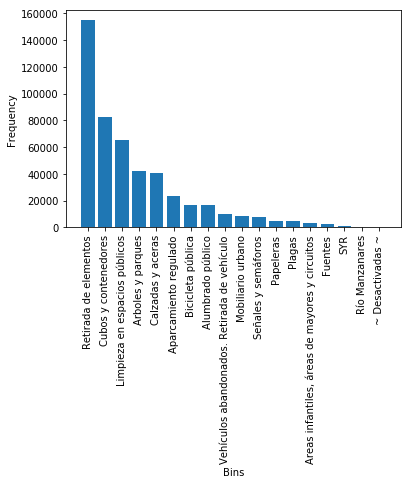

In [20]:
# Histogram of 2019 Madrid incidents 
x = df_Madrid_Complaints_INCIDENT_TYPES_index['CATEGORIA_NIVEL1']
y = df_Madrid_Complaints_INCIDENT_TYPES_index['TIPO_INCIDENCIA']

plt.bar(x,y,align='center')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.xticks(rotation='vertical')
plt.show()

In [21]:
# Left outer join of pollution and incidents on 'DISTRITO'
df_Incidents_District = df_Madrid_Complaints_short.groupby(['DISTRITO']).count()
df_Incidents_District = df_Incidents_District.drop(['CATEGORIA_NIVEL1'], axis=1)
df_Incidents_District = df_Incidents_District.sort_values(by='TIPO_INCIDENCIA', ascending=False)

df_Joined_Districts_Pollution_Incidents = pd.merge(final_pollution_df, df_Incidents_District, on='DISTRITO', how='left')

df_Joined_Districts_Pollution_Incidents

,DISTRITO,LAT,LON,NO2,PM10,OZONE,NO2_groups,PM10_groups,OZONE_groups,Pollution_scoring,TIPO_INCIDENCIA
0,Hortaleza,40.469457,-3.640482,31.000000,14.000000,80.428571,1,1,1,1.000000,25863
1,Carabanchel,40.383669,-3.727989,33.000000,16.000000,123.000000,1,1,2,1.333333,26378
2,Arganzuela,40.402733,-3.695403,34.000000,17.000000,80.428571,2,1,1,1.333333,26151
3,Fuencarral - El Pardo,40.478611,-3.709722,25.666667,15.974359,110.000000,1,1,2,1.333333,28491
4,Moncloa - Aravaca,40.435151,-3.718765,30.000000,15.230769,99.214286,1,1,2,1.333333,23974
5,Retiro,40.408072,-3.676729,25.000000,17.461538,96.000000,1,2,2,1.666667,19394
6,Vicalvaro,40.404200,-3.608060,34.583333,17.461538,80.428571,2,2,1,1.666667,6317
7,Ciudad Lineal,40.453333,-3.650000,34.000000,17.461538,1.000000,2,2,1,1.666667,30884
8,Latina,40.402461,-3.741294,34.583333,17.461538,80.428571,2,2,1,1.666667,26597
9,San Blas - Canillejas,40.426001,-3.612764,34.583333,17.461538,80.428571,2,2,1,1.666667,19370


In [22]:
# Ranking DISTRICT by incidents (similar to RFM analysis)

# Create labels for Incidents
Incidents_labels = range(1, 5)

# Assign labels to 4 equal percentile groups using 'qcut'
Incidents_scoring = pd.qcut(df_Joined_Districts_Pollution_Incidents['TIPO_INCIDENCIA'], q=4, labels = Incidents_labels, duplicates='drop')

# Create new column: Incidents_groups
df_Joined_Districts_Pollution_Incidents_Ranked = df_Joined_Districts_Pollution_Incidents.assign(Incidents_scoring = Incidents_scoring.values)

final_pollution_incidents_df = df_Joined_Districts_Pollution_Incidents_Ranked

final_pollution_incidents_df

,DISTRITO,LAT,LON,NO2,PM10,OZONE,NO2_groups,PM10_groups,OZONE_groups,Pollution_scoring,TIPO_INCIDENCIA,Incidents_scoring
0,Hortaleza,40.469457,-3.640482,31.000000,14.000000,80.428571,1,1,1,1.000000,25863,2
1,Carabanchel,40.383669,-3.727989,33.000000,16.000000,123.000000,1,1,2,1.333333,26378,3
2,Arganzuela,40.402733,-3.695403,34.000000,17.000000,80.428571,2,1,1,1.333333,26151,3
3,Fuencarral - El Pardo,40.478611,-3.709722,25.666667,15.974359,110.000000,1,1,2,1.333333,28491,4
4,Moncloa - Aravaca,40.435151,-3.718765,30.000000,15.230769,99.214286,1,1,2,1.333333,23974,2
5,Retiro,40.408072,-3.676729,25.000000,17.461538,96.000000,1,2,2,1.666667,19394,2
6,Vicalvaro,40.404200,-3.608060,34.583333,17.461538,80.428571,2,2,1,1.666667,6317,1
7,Ciudad Lineal,40.453333,-3.650000,34.000000,17.461538,1.000000,2,2,1,1.666667,30884,4
8,Latina,40.402461,-3.741294,34.583333,17.461538,80.428571,2,2,1,1.666667,26597,3
9,San Blas - Canillejas,40.426001,-3.612764,34.583333,17.461538,80.428571,2,2,1,1.666667,19370,2


In [87]:
# create MADRID map showing districts by number of incidents
MADRID_MAP_HEATMAP_INCIDENTS = folium.Map(location=[40.4165001, -3.7025599], zoom_start=10) # Madrid GPS coordinates, zoom level of 10

MADRID_MAP_HEATMAP_INCIDENTS.choropleth(
 # geo_data cant be used in this notebook, very time-consuming issue to find out! 
 geo_path = 'madrid_distritos.geojson',
 data = final_pollution_incidents_df,
 columns = ['DISTRITO', 'Incidents_scoring'],
 key_on = 'feature.properties.nombre',
 fill_color = 'YlOrRd',
 fill_opacity = 0.7,
 line_opacity = 0.2,
 legend_name = 'Madrid: 2019 incidents scoring by district')

#Display Map
MADRID_MAP_HEATMAP_INCIDENTS
# higher scores show higher numbers of incidents

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.


In [24]:
# Connecting to FourSquare API
# Based on New York cluster notebook created by Alex Aklson and Polong Lin

CLIENT_ID = 'SANITIZED' # your Foursquare ID
CLIENT_SECRET = 'SANITIZED' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
print('API user parameters ready')

API user parameters ready


In [25]:
    # Function to extract VENUES data for all DISTRICTS in MADRID
    # Based on New York cluster notebook created by Alex Aklson and Polong Lin

    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 750 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['DISTRITO', 
                  'LAT', 
                  'LON', 
                  'Venue', 
                  'Venue LAT', 
                  'Venue LON', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
# Run function
MADRID_venues = getNearbyVenues(names=final_pollution_incidents_df['DISTRITO'],
                                   latitudes=final_pollution_incidents_df['LAT'],
                                   longitudes=final_pollution_incidents_df['LON'])

Hortaleza
Carabanchel
Arganzuela
Fuencarral - El Pardo
Moncloa - Aravaca
Retiro
Vicalvaro
Ciudad Lineal
Latina
San Blas - Canillejas
Puente de Vallecas
Villa de Vallecas
Centro
Tetuan
Chamartin
Barajas
Moratalaz
Villaverde
Chamberi
Salamanca
Usera


In [27]:
#Reviewing output
print(MADRID_venues.shape)
MADRID_venues.head()

(705, 7)


,DISTRITO,LAT,LON,Venue,Venue LAT,Venue LON,Venue Category
0,Hortaleza,40.469457,-3.640482,A'Fenestella,40.468188,-3.638647,Pizza Place
1,Hortaleza,40.469457,-3.640482,Sidrería Arturo,40.473014,-3.641465,Spanish Restaurant
2,Hortaleza,40.469457,-3.640482,Carrefour,40.469461,-3.640916,Supermarket
3,Hortaleza,40.469457,-3.640482,Springfield,40.469483,-3.640922,Clothing Store
4,Hortaleza,40.469457,-3.640482,Dunkin' Coffee,40.469456,-3.641243,Donut Shop


In [28]:
# Unique venue categories in english show FourSquare data oriented towards Tourists
# might be due to API language settings because FourSquare returns 30 of them
# further API requests returned "Max retries exceeded with url" message, so I continue with data sample retrieved (705 venues)

MADRID_venues_count = MADRID_venues.groupby(['Venue Category']).count()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
MADRID_venues_count

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,DISTRITO,LAT,LON,Venue,Venue LAT,Venue LON
Venue Category,,,,,,
American Restaurant,2,2,2,2,2,2
Arepa Restaurant,2,2,2,2,2,2
Argentinian Restaurant,5,5,5,5,5,5
Art Gallery,3,3,3,3,3,3
Art Museum,2,2,2,2,2,2
Art Studio,1,1,1,1,1,1
Asian Restaurant,10,10,10,10,10,10
Athletics & Sports,1,1,1,1,1,1
BBQ Joint,2,2,2,2,2,2


In [29]:
# Listing top 10 venues
MADRID_TopTen_Venues = MADRID_venues_count.groupby(['Venue Category']).sum()
MADRID_TopTen_Venues = MADRID_TopTen_Venues.sort_values(by='DISTRITO', ascending=False)
MADRID_TopTen_Venues.head(10)

,DISTRITO,LAT,LON,Venue,Venue LAT,Venue LON
Venue Category,,,,,,
Spanish Restaurant,73,73,73,73,73,73
Restaurant,44,44,44,44,44,44
Tapas Restaurant,34,34,34,34,34,34
Grocery Store,23,23,23,23,23,23
Bakery,23,23,23,23,23,23
Pizza Place,20,20,20,20,20,20
Bar,18,18,18,18,18,18
Hotel,18,18,18,18,18,18
Burger Joint,15,15,15,15,15,15


In [30]:
# retrieve list of top venues to query dataframe
df_topten_venues = MADRID_TopTen_Venues.head(10) 

list_topten_venues = list(df_topten_venues.index.values)
list_topten_venues

['Spanish Restaurant',
 'Restaurant',
 'Tapas Restaurant',
 'Grocery Store',
 'Bakery',
 'Pizza Place',
 'Bar',
 'Hotel',
 'Burger Joint',
 'Plaza']

In [31]:
# Select top 10 venues from MADRID_venues dataframe to perform de analysis
MADRID_venues_toptenlist = MADRID_venues[MADRID_venues['Venue Category'].isin(list_topten_venues)]
print(MADRID_venues_toptenlist.shape)
MADRID_venues_toptenlist.head()

(282, 7)


,DISTRITO,LAT,LON,Venue,Venue LAT,Venue LON,Venue Category
0,Hortaleza,40.469457,-3.640482,A'Fenestella,40.468188,-3.638647,Pizza Place
1,Hortaleza,40.469457,-3.640482,Sidrería Arturo,40.473014,-3.641465,Spanish Restaurant
5,Hortaleza,40.469457,-3.640482,La Arrieria,40.467673,-3.637494,Restaurant
7,Hortaleza,40.469457,-3.640482,Glorieta Mar de Cristal,40.469429,-3.638331,Plaza
15,Hortaleza,40.469457,-3.640482,Mesón Los Maños,40.467325,-3.638388,Spanish Restaurant


In [32]:
# Counting top ten venues per district
MADRID_venues_toptenlist_GroupBy = MADRID_venues_toptenlist.groupby('DISTRITO').count()

MADRID_venues_toptenlist_GroupBy = MADRID_venues_toptenlist_GroupBy.drop(['LAT', 'LON', 'Venue', 'Venue LON', 'Venue LAT'], axis=1)

MADRID_venues_toptenlist_GroupBy.sort_values(by='Venue Category', ascending=False)

,Venue Category
DISTRITO,
Arganzuela,38
Chamberi,37
Centro,29
Chamartin,29
Salamanca,19
Barajas,18
Moncloa - Aravaca,18
Retiro,16
Ciudad Lineal,12


In [33]:
# Ranking DISTRICT by Venues (similar to RFM analysis)

# Create labels for Venues
Venues_labels = range(1, 5)

# Assign labels to 4 equal percentile groups using 'qcut' --> *(-1) so that lower scores imply larger numbers of venues
Venues_scoring = pd.qcut(MADRID_venues_toptenlist_GroupBy['Venue Category']*(-1), q=4, labels = Venues_labels, duplicates='drop')

# Create new column: Venues_groups
MADRID_venues_toptenlist_GroupBy_Ranked = MADRID_venues_toptenlist_GroupBy.assign(Venues_scoring = Venues_scoring.values)

final_venues_df = MADRID_venues_toptenlist_GroupBy_Ranked.sort_values(by='Venues_scoring')

final_venues_df

,Venue Category,Venues_scoring
DISTRITO,,
Arganzuela,38,1
Salamanca,19,1
Chamberi,37,1
Chamartin,29,1
Moncloa - Aravaca,18,1
Barajas,18,1
Centro,29,1
Ciudad Lineal,12,2
Fuencarral - El Pardo,10,2


In [93]:
# adding the venues scoring to pollution and incidents and generating a combined SUM score (the lower, the better)
# Further scoring attributes can be added: crime rates, traffic accidents, etc
df_Joined_Districts_Pollution_Incidents_Venues = pd.merge(final_pollution_incidents_df, final_venues_df, on='DISTRITO', how='left')

df_Joined_Districts_Pollution_Incidents_Venues['Pollution_scoring'] = df_Joined_Districts_Pollution_Incidents_Venues['Pollution_scoring'].astype(np.int8)
df_Joined_Districts_Pollution_Incidents_Venues['Incidents_scoring'] = df_Joined_Districts_Pollution_Incidents_Venues['Incidents_scoring'].astype(np.int8)
df_Joined_Districts_Pollution_Incidents_Venues['Venues_scoring'] = df_Joined_Districts_Pollution_Incidents_Venues['Venues_scoring'].astype(np.int8)

df_Joined_Districts_Pollution_Incidents_Venues['Combined_Score']  = df_Joined_Districts_Pollution_Incidents_Venues['Pollution_scoring'] + df_Joined_Districts_Pollution_Incidents_Venues['Incidents_scoring'] + df_Joined_Districts_Pollution_Incidents_Venues['Venues_scoring']

df_Joined_Districts_Pollution_Incidents_Venues.sort_values(by='Combined_Score')

SHOW = df_Joined_Districts_Pollution_Incidents_Venues[['DISTRITO','Pollution_scoring', 'Incidents_scoring', 'Venues_scoring','Combined_Score']]
SHOW.sort_values(by='Combined_Score')

,DISTRITO,Pollution_scoring,Incidents_scoring,Venues_scoring,Combined_Score
15,Barajas,2,1,1,4
4,Moncloa - Aravaca,1,2,1,4
10,Puente de Vallecas,1,2,2,5
2,Arganzuela,1,3,1,5
5,Retiro,1,2,2,5
6,Vicalvaro,1,1,3,5
16,Moratalaz,2,1,3,6
14,Chamartin,2,3,1,6
11,Villa de Vallecas,2,1,3,6
0,Hortaleza,1,2,3,6


In [88]:
# create MADRID map showing districts by combined score
MADRID_MAP_HEATMAP_COMBINED = folium.Map(location=[40.4165001, -3.7025599], zoom_start=10) # Madrid GPS coordinates, zoom level of 10

MADRID_MAP_HEATMAP_COMBINED.choropleth(
 # geo_data cant be used in this notebook, very time-consuming issue to find out! 
 geo_path = 'madrid_distritos.geojson',
 data = df_Joined_Districts_Pollution_Incidents_Venues,
 columns = ['DISTRITO', 'Combined_Score'],
 key_on = 'feature.properties.nombre',
 fill_color = 'YlOrRd',
 fill_opacity = 0.7,
 line_opacity = 0.2,
 legend_name = 'Madrid: 2019 combined scoring by district')

# visualize district markers in the map - wikipedia coordinates
for index, row in df_Madrid_Districts_GPS.iterrows():
    label = folium.Popup(str([row["DISTRITO"]]))
    folium.CircleMarker(location=[row["LAT"], row["LON"]],
    color='#5cb85c',
    popup=label).add_to(MADRID_MAP_HEATMAP_COMBINED)

#Display Map
MADRID_MAP_HEATMAP_COMBINED
# the lower the score, the better scoring the district has
# please note that further attributes can be considered in the scoring: crime rates, traffic incidents, price per square meter, etc
# also worth tweaking wikipedia coordinates as some of these fall right between district borders

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


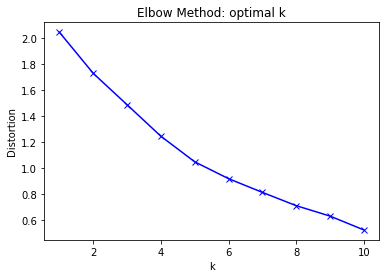

In [79]:
# k means: determine k with elbow method - Based on source: https://pythonprogramminglanguage.com/kmeans-elbow-method/
# Standardize features by removing the mean and scaling to unit variance using StandardScaler

MADRID_grouped_clustering = df_Joined_Districts_Pollution_Incidents_Venues.drop(['DISTRITO','LAT','LON','NO2_groups','PM10_groups','OZONE_groups','Pollution_scoring','Incidents_scoring', 'Venues_scoring', 'Combined_Score'], axis=1)

TEST = MADRID_grouped_clustering
TEST_SCALED = StandardScaler().fit(TEST).transform(TEST)

# run k-means clustering
# kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# k means determine k
distortions = []
K = range(1,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(TEST_SCALED)
    kmeanModel.fit(TEST_SCALED)
    distortions.append(sum(np.min(cdist(TEST_SCALED, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / TEST_SCALED.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method: optimal k')
plt.show()

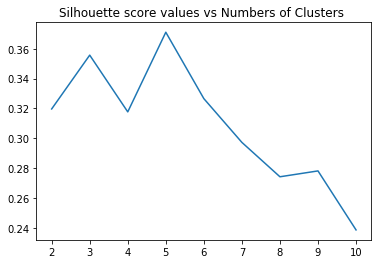

Optimal number of components is:  5


In [80]:
# elbow method returns an ambigous result to pick a suitable point where the real bend occurs
# checking now with silhouette coefficient plot - Based on example from: http://ros-developer.com/2017/12/04/silhouette-coefficient-finding-optimal-number-clusters/
silhouette_score_values=list()
 
NumberOfClusters=range(2,11) # Valid values are 2 to n_samples - 1 (inclusive)
 
for i in NumberOfClusters:
    
    classifier=cluster.KMeans(i,init='k-means++', n_init=10, max_iter=400, tol=0.0001, verbose=0, random_state=None, copy_x=True)
    classifier.fit(TEST_SCALED)
    labels= classifier.predict(TEST_SCALED)
    silhouette_score_values.append(sklearn.metrics.silhouette_score(TEST_SCALED,labels ,metric='euclidean', sample_size=None, random_state=None))
 
plt.plot(NumberOfClusters, silhouette_score_values)
plt.title("Silhouette score values vs Numbers of Clusters ")
plt.show()
 
Optimal_NumberOf_Components=NumberOfClusters[silhouette_score_values.index(max(silhouette_score_values))]
print ("Optimal number of components is: ",Optimal_NumberOf_Components)

#k = 5 is the value to use

In [81]:
# set number of clusters as per silhouette coefficient plot method
# data is based on pollution levels, incidents and number of top venues - data was normalized with standardscaler
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(TEST_SCALED)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [82]:
kmeans.labels_

array([3, 3, 1, 3, 3, 3, 4, 0, 4, 4, 4, 4, 0, 4, 1, 4, 4, 4, 1, 2, 2],
      dtype=int32)

In [83]:
# add clustering labels - 
df_MADRID_Districts_Pollution_Incidents_Venues_KMEANS = df_Joined_Districts_Pollution_Incidents_Venues

df_MADRID_Districts_Pollution_Incidents_Venues_KMEANS.insert(3, 'Cluster Labels', kmeans.labels_)

In [84]:
df_MADRID_Districts_Pollution_Incidents_Venues_KMEANS.sort_values(by='Cluster Labels')

,DISTRITO,LAT,LON,Cluster Labels,NO2,PM10,OZONE,NO2_groups,PM10_groups,OZONE_groups,Pollution_scoring,TIPO_INCIDENCIA,Incidents_scoring,Venue Category,Venues_scoring,Combined_Score
12,Centro,40.415347,-3.707371,0,36.000000,17.461538,18.000000,3,2,1,2,53426,4,29,1,7
7,Ciudad Lineal,40.453333,-3.650000,0,34.000000,17.461538,1.000000,2,2,1,1,30884,4,12,2,7
18,Chamberi,40.432792,-3.697186,1,38.000000,19.000000,80.428571,4,4,1,3,30857,4,37,1,8
2,Arganzuela,40.402733,-3.695403,1,34.000000,17.000000,80.428571,2,1,1,1,26151,3,38,1,5
14,Chamartin,40.453333,-3.677500,1,36.500000,17.730769,80.428571,3,3,1,2,26396,3,29,1,6
20,Usera,40.381336,-3.706856,2,53.000000,20.000000,34.000000,4,4,1,3,16519,1,1,4,8
19,Salamanca,40.430000,-3.677778,2,51.000000,21.000000,42.000000,4,4,1,3,28093,4,19,1,8
0,Hortaleza,40.469457,-3.640482,3,31.000000,14.000000,80.428571,1,1,1,1,25863,2,6,3,6
5,Retiro,40.408072,-3.676729,3,25.000000,17.461538,96.000000,1,2,2,1,19394,2,16,2,5
4,Moncloa - Aravaca,40.435151,-3.718765,3,30.000000,15.230769,99.214286,1,1,2,1,23974,2,18,1,4


In [85]:
# create MADRID map showing districts by kmeans cluster label
MADRID_MAP_HEATMAP_KMEANS = folium.Map(location=[40.4165001, -3.7025599], zoom_start=10) # Madrid GPS coordinates, zoom level of 10

MADRID_MAP_HEATMAP_KMEANS.choropleth(
 # geo_data cant be used in this notebook, very time-consuming issue to find out! 
 geo_path = 'madrid_distritos.geojson',
 data = df_MADRID_Districts_Pollution_Incidents_Venues_KMEANS,
 columns = ['DISTRITO', 'Cluster Labels'],
 key_on = 'feature.properties.nombre',
 fill_color = 'YlOrRd',
 fill_opacity = 0.7,
 line_opacity = 0.2,
 legend_name = 'Madrid: 2019 clusters')

# visualize district markers in the map - wikipedia coordinates
for index, row in df_MADRID_Districts_Pollution_Incidents_Venues_KMEANS.iterrows():
    label = folium.Popup(str([row["DISTRITO"]])+' Cluster:'+str([row["Cluster Labels"]]))
    folium.CircleMarker(location=[row["LAT"], row["LON"]],
    color='#5cb85c',
    popup=label).add_to(MADRID_MAP_HEATMAP_KMEANS)

#Display Map
MADRID_MAP_HEATMAP_KMEANS

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.


### Cluster 0: 'Central - Busy districts'
### Cluster 1: 'Central - Busy enough districts (I)'
### Cluster 2: 'Central - Busy enough districts (II)'
### Cluster 3: 'North-western rim districts'
### Cluster 4: 'South-eastern rim + La Latina'

# END OF NOTEBOOK